### This notebook runs through the MNIST dataset, exploring dataset statistics and connections we can make to uncertainty.

Dataset setup (MNIST has issues with copyright and sometimes Yann LeCunn's links give us a 403 error.)

In [447]:
import os
import torch
import subprocess as sp
import random

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST, read_image_file, read_label_file
from torchvision.datasets.utils import extract_archive
from torchvision.transforms import v2, functional as F, transforms as transforms

%matplotlib inline

In [14]:
def patched_download(self): #https://stackoverflow.com/questions/66577151/http-error-when-trying-to-download-mnist-data
    """wget patched download method.
    """
    if self._check_exists():
        return

    os.makedirs(self.raw_folder, exist_ok=True)
    os.makedirs(self.processed_folder, exist_ok=True)

    # download files
    for url, md5 in self.resources:
        filename = url.rpartition('/')[2]
        download_root = os.path.expanduser(self.raw_folder)
        extract_root = None
        remove_finished = False

        if extract_root is None:
            extract_root = download_root
        if not filename:
            filename = os.path.basename(url)
        
        # Use wget to download archives
        sp.run(["wget", url, "-P", download_root])

        archive = os.path.join(download_root, filename)
        print("Extracting {} to {}".format(archive, extract_root))
        extract_archive(archive, extract_root, remove_finished)

    # process and save as torch files
    print('Processing...')

    training_set = (
        read_image_file(os.path.join(self.raw_folder, 'train-images-idx3-ubyte')),
        read_label_file(os.path.join(self.raw_folder, 'train-labels-idx1-ubyte'))
    )
    test_set = (
        read_image_file(os.path.join(self.raw_folder, 't10k-images-idx3-ubyte')),
        read_label_file(os.path.join(self.raw_folder, 't10k-labels-idx1-ubyte'))
    )
    with open(os.path.join(self.processed_folder, self.training_file), 'wb') as f:
        torch.save(training_set, f)
    with open(os.path.join(self.processed_folder, self.test_file), 'wb') as f:
        torch.save(test_set, f)

    print('Done!')


In [ ]:
MNIST.download = patched_download

mnist_train = MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = MNIST("../data", train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(mnist_train, batch_size=1, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=1, shuffle=False)

Data statistics\
Note the sizes of training and testing data

In [80]:
data, target = next(iter(train_loader))
x = torch.squeeze(data, dim = 0)
x.shape

torch.Size([1, 28, 28])

In [448]:
print(f'Training size: {len(mnist_train)}')
print(f'Testing size: {len(mnist_test)}')
print(f'Input tensor shape with label shape: {data.shape}, {target.shape}')
print(f'Batch size: {train_loader.batch_size}')
print(mnist_test.classes)

Training size: 60000
Testing size: 10000
Input tensor shape with label shape: torch.Size([1, 1, 28, 28]), torch.Size([1])
Batch size: 1
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [483]:
def get_n_data(n:int):
    data_li = []
    label_li = []
    for i in range(n):
        data, target = next(iter(train_loader))
        data_li.append(data)
        label_li.append(target)
    return [data_li, label_li]

In [596]:
def show_image(data, target):
    img = data[0].reshape(28, 28)
    plt.title(f"Target: {target[0]}")
    plt.imshow(img, cmap = 'gray')

def show_multiple_images(data: list, target: list):
    # This function won't show more than 10 images
    num_imgs = len(data)
    num_cols = 1 if num_imgs < 6 else 2

    fig, axes = plt.subplots(num_cols, num_imgs, figsize = (14, 5))
    for i in range(num_imgs):
        img = data[i]
        label = target[i]
        img = img[0].reshape(28,28)
        ax = axes[i]
        ax.imshow(img, cmap = 'gray')
        ax.set_title(f'Label: {label if isinstance(label, int) else label[0]}')
    plt.tight_layout()
    plt.show()

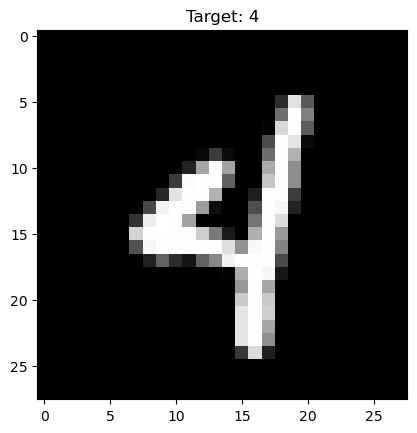

In [450]:
new_img, label = next(iter(train_loader))
show_image(new_img,label)

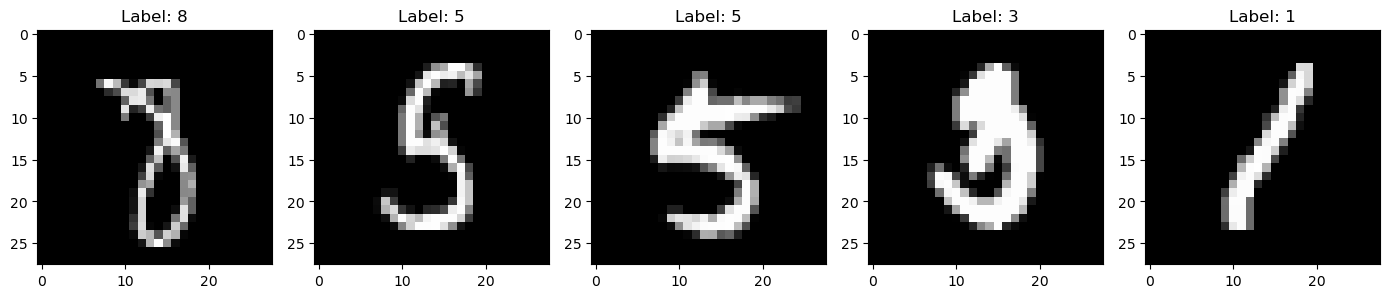

In [499]:
five_imgs_data, five_imgs_labels = get_n_data(5)
show_multiple_images(five_imgs_data, five_imgs_labels)

### Bounding Box representations - How can we find the "meat" of the image?
Bounding Boxes are usually outputs of image classification models, so we can use them exactly for their purpose to visualize object boundaries.

* Method 1 - Hardcoded
    * The hardcoded method finds all the non_zero pixels in the image, denoting the location of the number in the image. Matplotlib adds a red rectangle around the location's coordinate values.\
* Method 2 - What does a trained model see?
    * If we have a trained image classification model, we may be able to find bounding boxes zero-shot. Obviously, this can be improved by training the classification model on labeled bounded boxes for MNIST, but we're just trying to visualize what a non-specialized (general) model may see.

In [500]:
def get_bounding_box(img, target):
    bounding_img = img.squeeze().numpy()

    nonzero_indices = np.argwhere(bounding_img > 0)
    top_left = nonzero_indices.min(axis=0)
    bottom_right = nonzero_indices.max(axis=0)

    plt.imshow(bounding_img, cmap='gray')

    plt.gca().add_patch(
        plt.Rectangle((top_left[1], top_left[0]), bottom_right[1] - top_left[1], bottom_right[0] - top_left[0], 
                    edgecolor='red', facecolor='none', linewidth=2)
    )
    plt.show()

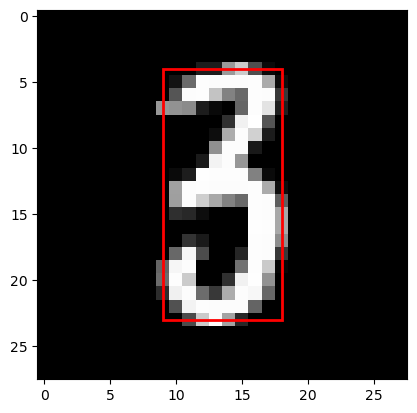

In [265]:
bounding_img, bounding_target = next(iter(train_loader))
get_bounding_box(bounding_img, bounding_target)

Now let's use ResNet, a popular feature extractor for object detection. ResNet was trained on ImageNet, a seperate dataset from MNIST, so in theory, all predictions are zero-shot.

In [104]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

/Users/manjunathshettar/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/manjunathshettar/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/manjunathshettar/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 57.0MB/s] 


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [143]:
def get_bounding_box_from_resnet(image_tensor):
    image_tensor = image_tensor.repeat(3, 1, 1)
    image_tensor = image_tensor.unsqueeze(0)
    
    with torch.no_grad():
        predictions = model(image_tensor)
    
    boxes = predictions[0]['boxes']
    return boxes

def bound_bbox(image_tensor, boxes):
    image_np = image_tensor.squeeze().numpy()
    plt.imshow(image_np, cmap='gray')
    
    for box in boxes:
        plt.gca().add_patch(
            plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                          edgecolor='red', facecolor='none', linewidth=2)
        )
    plt.show()

torch.Size([1, 28, 28])
Patterns recognized by ResNet: 6


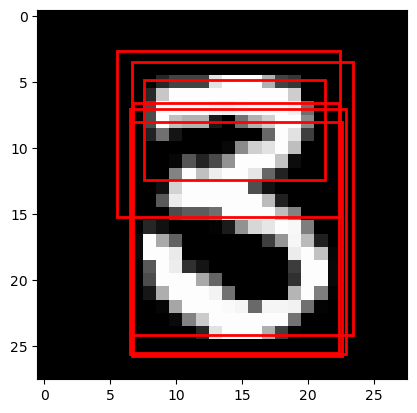

In [152]:
image, label = next(iter(train_loader))
boxes = get_bounding_box_from_resnet(image.squeeze(dim = 0))
print(f"Patterns recognized by ResNet: {boxes.shape[0]}")
bound_bbox(image, boxes)

Note that ResNet is giving us a varying amount of patterns in our data. This makes sense because digits have different structures, composing of patterns that may be represented in other digits or the digit entirely. The bounding boxes represent every time ResNet thinks it sees a new pattern.\

ResNet can be implicitly specified to show a single, covering bounding box, but the bounding box representations give us an idea of how patterns can be extracted from MNIST.

# Augmenting data: what may noise look like?

Sensors can go wrong all the time. Torchvision has a bunch of functions we can use to modulate sensor malfunctions.

In [237]:
def transform_imgs(transformation):
    images = []
    labels = []
    
    for _ in range(5):
        image, label = next(iter(train_loader))
        images.append(image.squeeze(0))
        labels.append(label)
    
    transformed_images = []
    for image in images:
        t = random.choice(transformation)
        transformed_images.append(t(image))
    
    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(5):
        image = transformed_images[i].numpy()
        image = image[0].reshape(28,28)

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Correct Label: {labels[i].item()}")
        axes[i].axis('off')
    
    plt.show()

A transformation may seem inconsequential, but lack of pooling layers or proper convolution, a model may misclassify these samples

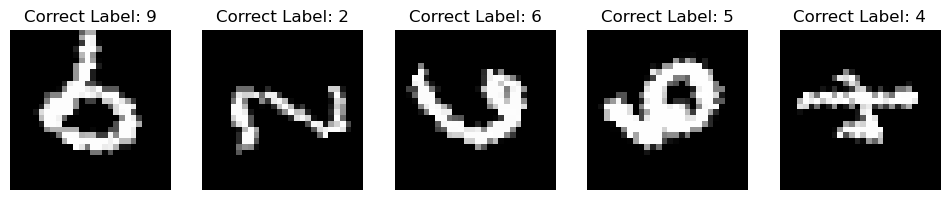

In [238]:
rotation_transform = transforms.RandomRotation(np.random.randint(0, 360))
transform_imgs([rotation_transform])

Adjusting the brightness of the image: notice how gray pixels become less and less frequent. This type of noise can cause issues with object detection in models. 

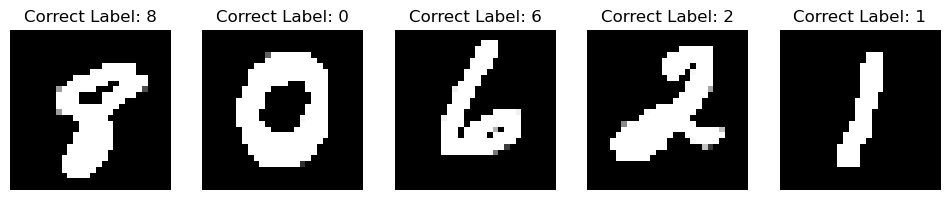

In [239]:
color = transforms.ColorJitter(brightness = 100)
transform_imgs([color])

In [253]:
blur = transforms.GaussianBlur(3)
invert = transforms.RandomInvert(0.5)
erase = transforms.RandomErasing(0.8)

Applying a random transformation out of a list to each image from a batch of images.

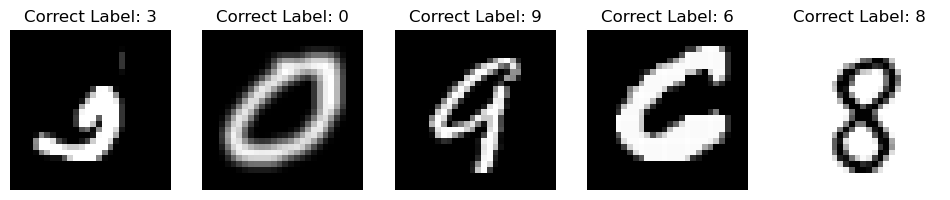

In [270]:
transform_imgs([invert, blur, erase])

Without a correct label, it may be difficult to classify an image if sensor noise is present. A softmax model will still need to classify an image with a class and without parts of the input data, it becomes notably hard to correctly classify. 

### Digit Similarity

In [290]:
def euclidean(img1, img2):
    img1 = img1.view(-1) / 255.0
    img2 = img2.view(-1) / 255.0

    dist = torch.sqrt(torch.sum((img1 - img2) ** 2))
    return dist.item()

In [546]:
def images_with_distance(img1, img2, target1, target2, dist):
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.title(f"Label: {target1.item()}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.title(f"Label: {target2.item()}")
    plt.axis('off')

    plt.suptitle(f"Distance: {dist:.2f}")
    plt.show()

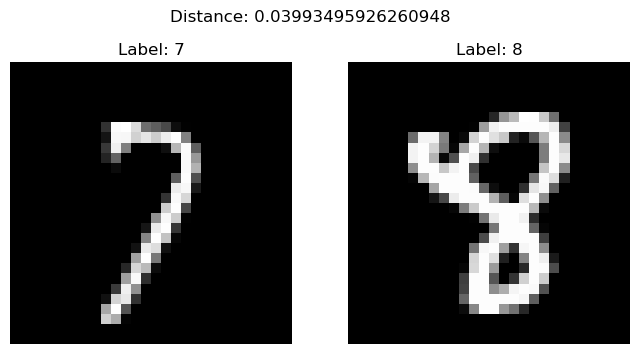

In [347]:
img1, target1 = next(iter(train_loader))
img2, target2 = next(iter(train_loader))
dist = euclidean(img1, img2)
images_with_distance(img1.squeeze(), img2.squeeze(), target1, target2, dist)

This distance value is deceivingly useless. It calculates all of the pixels found in the images, including the black or '0' ones. We need a way to calculate the Euclidean Distance of the features of each digit and compare those. 

In [576]:
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, resnet):
        super(ResNetFeatureExtractor, self).__init__()
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
    
    def forward(self, x):
        with torch.no_grad():
            x = self.resnet(x)
        return x.squeeze()


In [577]:
feature_extractor = ResNetFeatureExtractor(models.resnet18()).eval()
feature_extractor

ResNetFeatureExtractor(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [578]:
def img_for_resnet(img):
    transform = transforms.Compose([
        transforms.Pad((2, 2, 2, 2)),  # Pad the image to 32x32    
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    res_img = transforms.ToPILImage()(img.squeeze(0))
    res_img = transform(res_img).unsqueeze(0)
    return res_img

def feature_based_distance(img1, img2, model):
    features1 = model(img1)
    features2 = model(img2)
    
    distance = torch.sqrt(torch.sum((features1 - features2) ** 2))
    return distance.item()

def get_feature_maps(model, img):
    return model(img)

In [397]:
feature_maps = get_feature_maps(feature_extractor, img_for_resnet(next(iter(train_loader))))

In [579]:
i1, t1 = next(iter(train_loader))
i2, t2 = next(iter(train_loader))

res_i1 = img_for_resnet(i1)
res_i2 = img_for_resnet(i2)

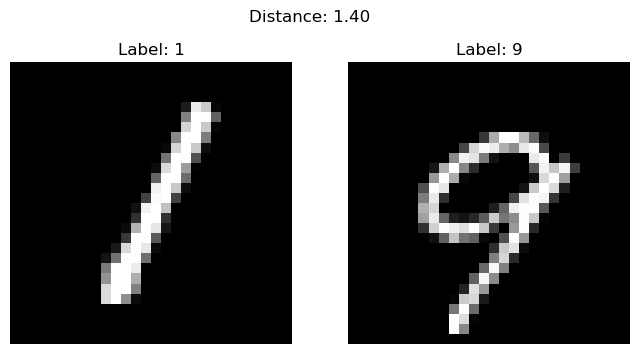

In [580]:
distance = feature_based_distance(res_i1, res_i2, feature_extractor)
images_with_distance(i1.squeeze(), i2.squeeze(), t1, t2, distance)

The following code takes approximately 30 seconds to run. We are collecting similar classes and measuring the distance between their feature maps and doing the same for classes that vary. We're getting 100 of each sample, but admittedly, this is bad practice since there is no distinction between labels. Let's try something better by handpicking samples. 

In [562]:
def get_dist():
    within_class_distances = []
    between_class_distances = []

    while len(within_class_distances) < 100:
        t_img1, t_label1 = next(iter(train_loader))
        t_img2, t_label2 = next(iter(train_loader))
        t_img3, t_label3 = next(iter(train_loader))

        t_img1 = img_for_resnet(t_img1)
        t_img2 = img_for_resnet(t_img2)
        t_img3 = img_for_resnet(t_img3)
        if t_label1 == t_label2:
            within_class_distances.append(feature_based_distance(t_img1, t_img2, feature_extractor))
        if t_label1 != t_label3 and len(between_class_distances) < 100:
            between_class_distances.append(feature_based_distance(t_img1, t_img3, feature_extractor))

    sns.histplot(within_class_distances, color='blue', label='Within-Class', kde=True)
    sns.histplot(between_class_distances, color='red', label='Between-Class', kde=True)
    plt.legend()
    plt.show()
    print(len(within_class_distances), len(between_class_distances))

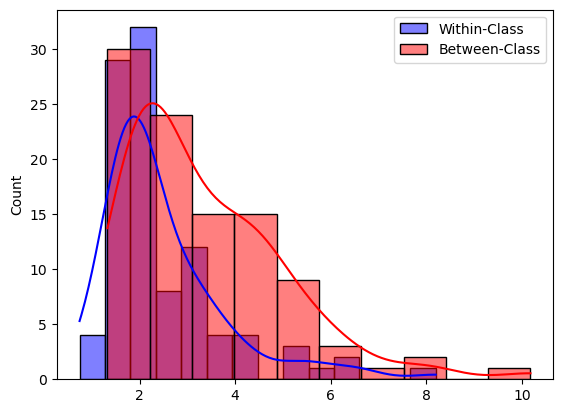

100 100


In [582]:
get_dist()

So, one thing is clear: we have significantly more between-class datapoints that have high distances, as expected.\

This is actually the only thing that stays consistent every time the code above is run. Sometimes, ther are no distance scores below 2 and sometimes the within-class has high frequency at distances 8 or 10. This is largely due to using ResNet.\

ResNet is a large Convolutional model, trained to receive high numbers of input data. Our MNIST data is compressed into a (28x28) tensor. Resizing this image, which we must do before it goes into ResNet, means we lose distinct features and our pixels get transformed (see: enlarging algorithms in Computer Graphics). Thus, we must only look at this as an abstraction. We cannot fully place our trust in any feature distance calculations to see how different the two images are emperically, but we can visually. 

In [583]:
def handpick_samples(dataset, target_label, num_samples):
    selected_data = []
    selected_labels = []
    
    for data, label in dataset:
        if label == target_label:
            selected_data.append(data)
            selected_labels.append(label)
            if len(selected_data) == num_samples:
                break
    
    return selected_data, selected_labels

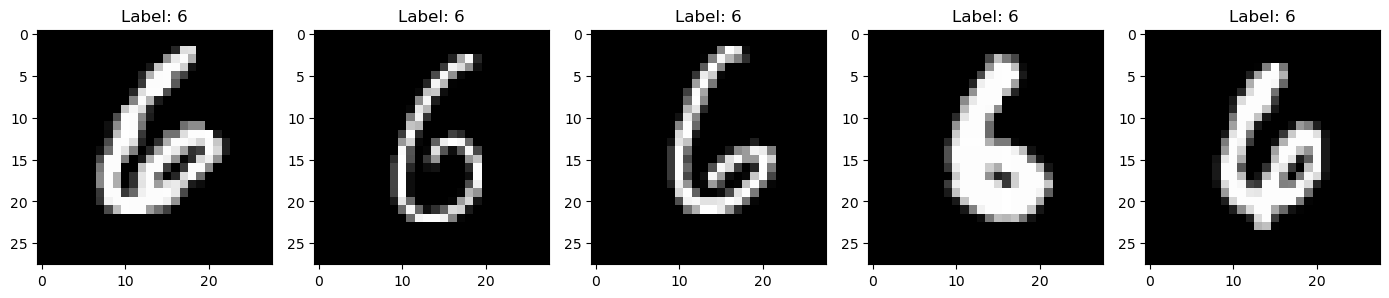

In [608]:
target_label = 6
num_samples = 5
selected_data, selected_labels = handpick_samples(mnist_train, target_label, num_samples)

show_multiple_images(selected_data, selected_labels)

In [609]:
res = map(img_for_resnet, (selected_data[i] for i in range(len(selected_data))))
res = list(res)

In [610]:
li = []
for i in range(1, len(res)):
    li.append(feature_based_distance(res[i-1], res[i], feature_extractor))

In [622]:
def show_image_with_prev_dist(img, dist):
    plt.figure(figsize=(10, 5))
    for i in range(len(img)):
        plt.subplot(2, 5, i+1)
        plt.imshow(img[i].squeeze(), cmap='gray')
        if i > 0:
            plt.title(f"Prev. dist. {dist[i - 1]:.2f}")
        plt.axis('off')
    plt.show()

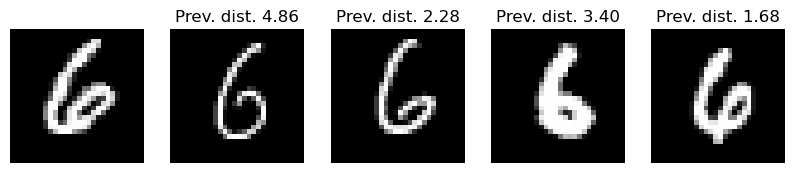

In [623]:
show_image_with_prev_dist(selected_data, li)

In [617]:
def handpick_samples():
    selected_data = []
    selected_labels = []
    data, label = next(iter(train_loader))
    for i in range(5):
        selected_data.append(data)
        selected_labels.append(label)
    
    return selected_data, selected_labels
struct = handpick_samples()

In [619]:
same_res = map(img_for_resnet, (struct[0][i] for i in range(5)))
same_res = list(same_res)

In [620]:
same_li = []
for i in range(1, len(same_res)):
    same_li.append(feature_based_distance(same_res[i-1], same_res[i], feature_extractor))

At least the feature extractor is showing zero distance for the same image.

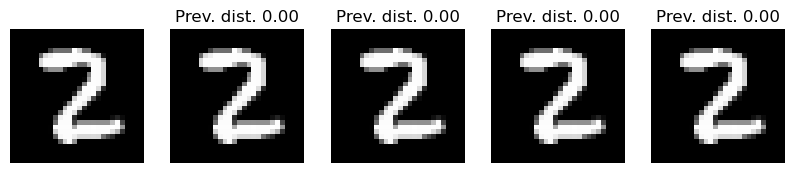

In [624]:
show_image_with_prev_dist(struct[0], same_li)

Now let's try and calculate distances for the augmented images.